In [ ]:
!pip install pytorch-tabular

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.4/891.4 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.8 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144555 sha256=354eaf80bb8539a1de0e401adb1a436dfdc8282e0a3c95e1a63e1f0e8a4377bf
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3

In [ ]:
!pip install pytorch-tabular --upgrade

Dataset Shape: (253680, 21)
Target Distribution:
Diabetes_012
0.0    0.842412
2.0    0.139333
1.0    0.018255
Name: proportion, dtype: float64
Using device: cpu
Epoch [10/50], Train Loss: 0.3970, Val Loss: 0.3944
Epoch [20/50], Train Loss: 0.3958, Val Loss: 0.3942
Epoch [30/50], Train Loss: 0.3957, Val Loss: 0.3940
Epoch [40/50], Train Loss: 0.3961, Val Loss: 0.3940
Epoch [50/50], Train Loss: 0.3953, Val Loss: 0.3945


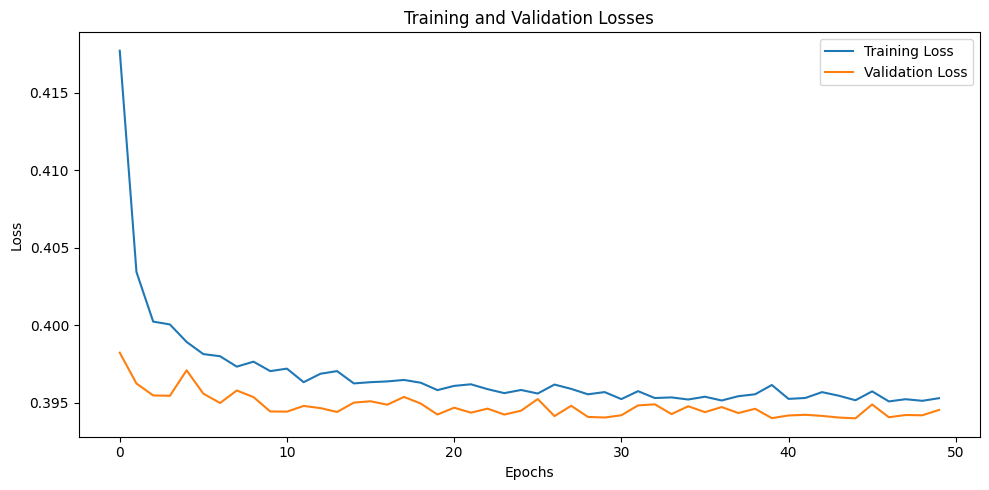


Classification Report:
              precision    recall  f1-score   support

Non-Diabetic       0.86      0.98      0.92     42741
Pre-Diabetic       0.00      0.00      0.00       926
    Diabetic       0.58      0.14      0.22      7069

    accuracy                           0.85     50736
   macro avg       0.48      0.37      0.38     50736
weighted avg       0.80      0.85      0.80     50736



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


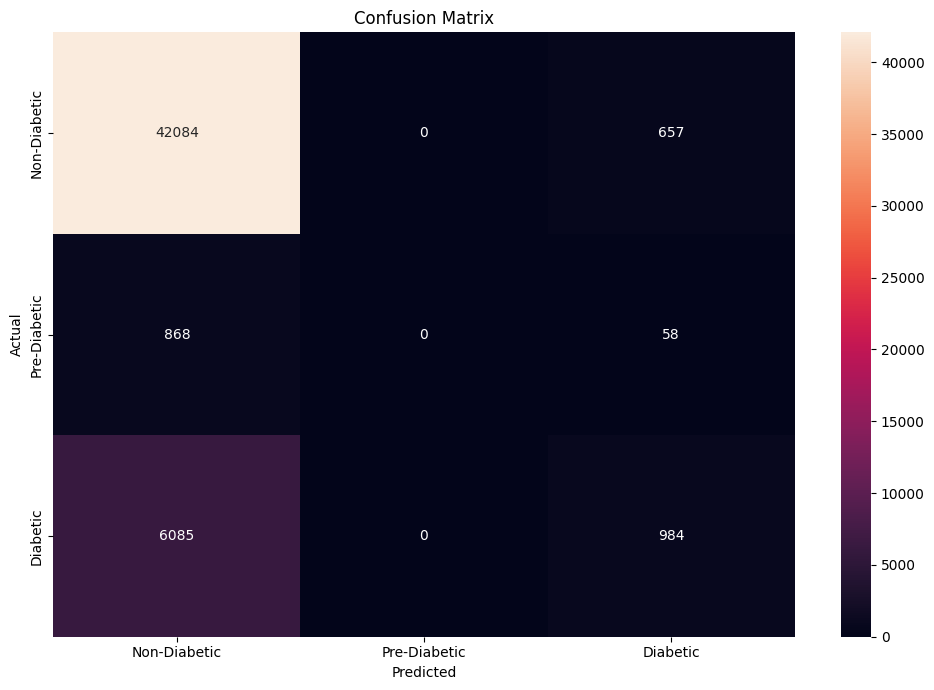

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)
torch.manual_seed(42)

df = pd.read_csv('/content/diabetes_012_health_indicators_BRFSS2015.csv')

X = df.drop('Diabetes_012', axis=1)
y = df['Diabetes_012']

print("Dataset Shape:", X.shape)
print("Target Distribution:")
print(y.value_counts(normalize=True))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_train_tensor = torch.LongTensor(y_train.values)
y_test_tensor = torch.LongTensor(y_test.values)

from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = min(64, len(X_train))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class TabTransformer(nn.Module):
    def __init__(self, input_dim, num_classes=3):
        super(TabTransformer, self).__init__()

        self.embedding = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.classifier = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x_embedded = self.embedding(x)

        return self.classifier(x_embedded)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

input_dim = X_train_tensor.shape[1]
model = TabTransformer(input_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, test_loader, epochs=50):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()

            outputs = model(batch_X)

            loss = criterion(outputs, batch_y)

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)

                outputs = model(batch_X)

                val_loss = criterion(outputs, batch_y)
                total_val_loss += val_loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(test_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/50], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    print("\nClassification Report:")
    class_names = ['Non-Diabetic', 'Pre-Diabetic', 'Diabetic']
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return cm

model = model.to(device)

train_losses, val_losses = train_model(model, train_loader, test_loader)

plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

confusion_matrix_result = evaluate_model(model, test_loader)

torch.save(model.state_dict(), 'diabetes_tabtransformer_model.pth')

Using device: cpu

--- Fold 1 ---


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(torch.tensor(outputs.cpu().detach()), dim=1).numpy(),
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct

Epoch 10: Val Loss 92.4415, Accuracy 0.9817


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(torch.tensor(outputs.cpu().detach()), dim=1).numpy(),
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct

Epoch 20: Val Loss 93.4058, Accuracy 0.9817


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(torch.tensor(outputs.cpu().detach()), dim=1).numpy(),
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct

Epoch 30: Val Loss 96.8769, Accuracy 0.9817


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(torch.tensor(outputs.cpu().detach()), dim=1).numpy(),
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct

Epoch 40: Val Loss 98.1893, Accuracy 0.9817


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(torch.tensor(outputs.cpu().detach()), dim=1).numpy(),
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct

Epoch 50: Val Loss 98.4531, Accuracy 0.9817


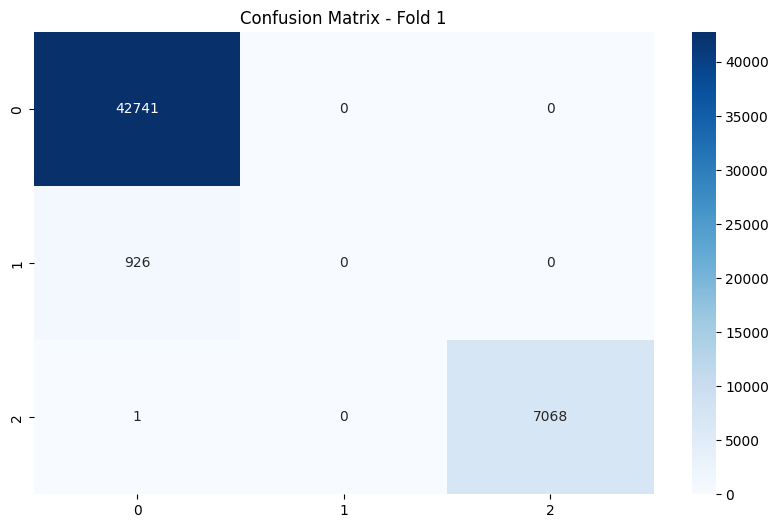


--- Fold 2 ---


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(torch.tensor(outputs.cpu().detach()), dim=1).numpy(),
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct

Epoch 10: Val Loss 92.5894, Accuracy 0.9817


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(torch.tensor(outputs.cpu().detach()), dim=1).numpy(),
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct

Epoch 20: Val Loss 93.9286, Accuracy 0.9817


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(torch.tensor(outputs.cpu().detach()), dim=1).numpy(),
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct

Epoch 30: Val Loss 95.6407, Accuracy 0.9817


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(torch.tensor(outputs.cpu().detach()), dim=1).numpy(),
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct

Epoch 40: Val Loss 97.1087, Accuracy 0.9817


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(torch.tensor(outputs.cpu().detach()), dim=1).numpy(),
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct

Epoch 50: Val Loss 97.4148, Accuracy 0.9817


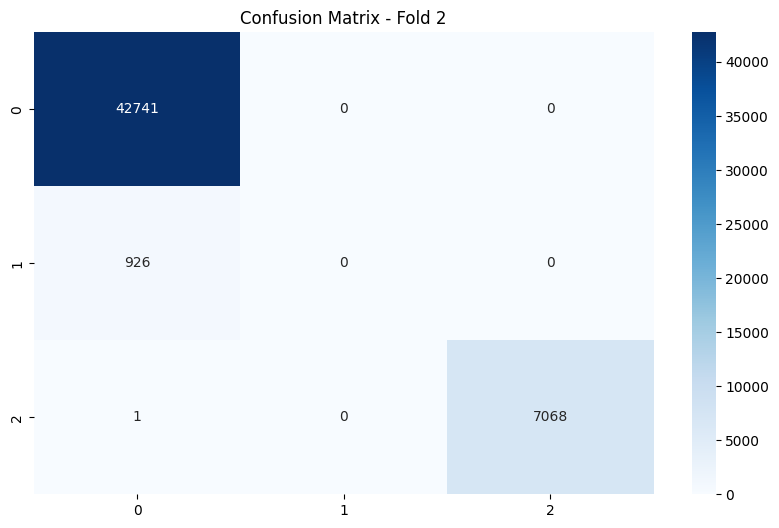


--- Fold 3 ---


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(torch.tensor(outputs.cpu().detach()), dim=1).numpy(),
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct

Epoch 10: Val Loss 93.7297, Accuracy 0.9817


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(torch.tensor(outputs.cpu().detach()), dim=1).numpy(),
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct

Epoch 20: Val Loss 95.4155, Accuracy 0.9817


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(torch.tensor(outputs.cpu().detach()), dim=1).numpy(),
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct

Epoch 30: Val Loss 97.6184, Accuracy 0.9817


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(torch.tensor(outputs.cpu().detach()), dim=1).numpy(),
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct

Epoch 40: Val Loss 99.1525, Accuracy 0.9817


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(torch.tensor(outputs.cpu().detach()), dim=1).numpy(),
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct

Epoch 50: Val Loss 100.1634, Accuracy 0.9817


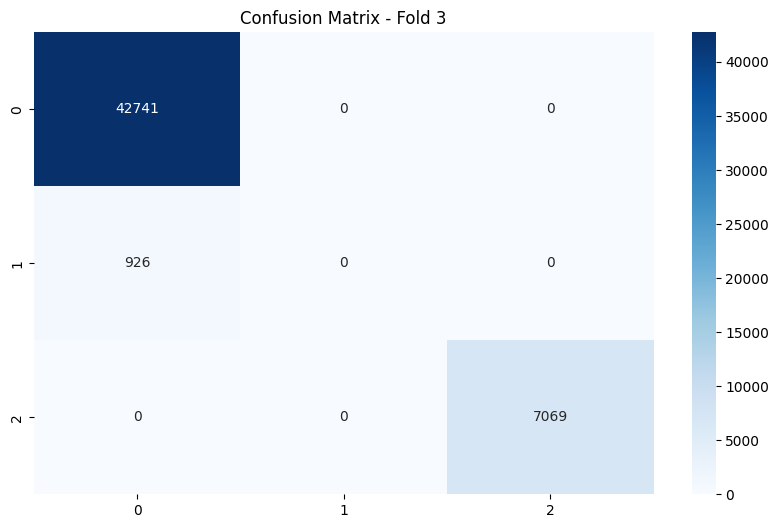


--- Fold 4 ---


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(torch.tensor(outputs.cpu().detach()), dim=1).numpy(),
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct

Epoch 10: Val Loss 95.0192, Accuracy 0.9815


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(torch.tensor(outputs.cpu().detach()), dim=1).numpy(),
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct

Epoch 20: Val Loss 94.4827, Accuracy 0.9817


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(torch.tensor(outputs.cpu().detach()), dim=1).numpy(),
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct

Epoch 30: Val Loss 96.5320, Accuracy 0.9817


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(torch.tensor(outputs.cpu().detach()), dim=1).numpy(),
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct

Epoch 40: Val Loss 97.4330, Accuracy 0.9817


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(torch.tensor(outputs.cpu().detach()), dim=1).numpy(),
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct

Epoch 50: Val Loss 97.6255, Accuracy 0.9817


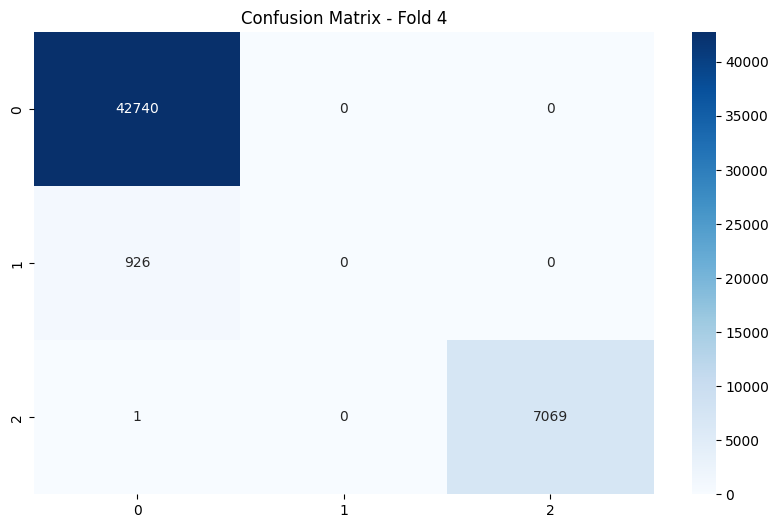


--- Fold 5 ---


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(torch.tensor(outputs.cpu().detach()), dim=1).numpy(),
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct

Epoch 10: Val Loss 94.1320, Accuracy 0.9816


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(torch.tensor(outputs.cpu().detach()), dim=1).numpy(),
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct

Epoch 20: Val Loss 95.4690, Accuracy 0.9817


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(torch.tensor(outputs.cpu().detach()), dim=1).numpy(),
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct

Epoch 30: Val Loss 98.8682, Accuracy 0.9817


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(torch.tensor(outputs.cpu().detach()), dim=1).numpy(),
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct

Epoch 40: Val Loss 99.3830, Accuracy 0.9817


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(torch.tensor(outputs.cpu().detach()), dim=1).numpy(),
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-37-fcd60fddcc32>:205: UserWarning: To copy construct

Epoch 50: Val Loss 99.5931, Accuracy 0.9817


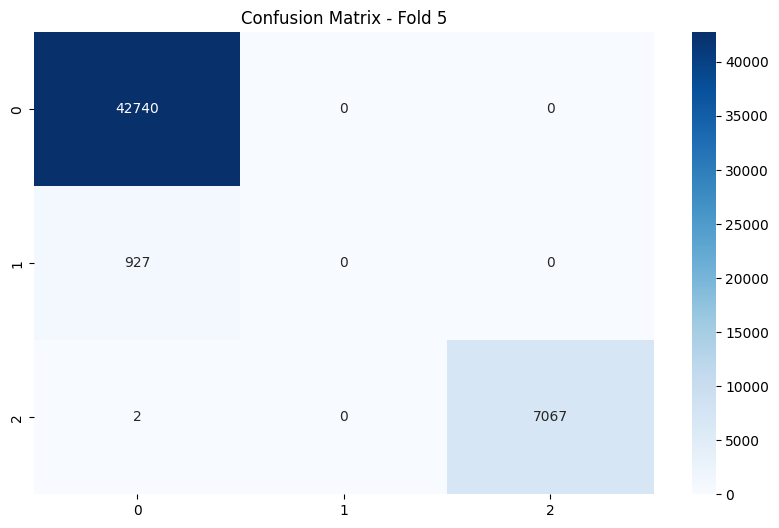


--- Cross-Validation Results ---
Accuracy: 0.9817 ± 0.0002
Balanced Accuracy: 0.6666 ± 0.0002
Precision: 0.9638 ± 0.0002
Recall: 0.9817 ± 0.0002
F1 Score: 0.9727 ± 0.0002
Roc Auc: 0.0000 ± 0.0000


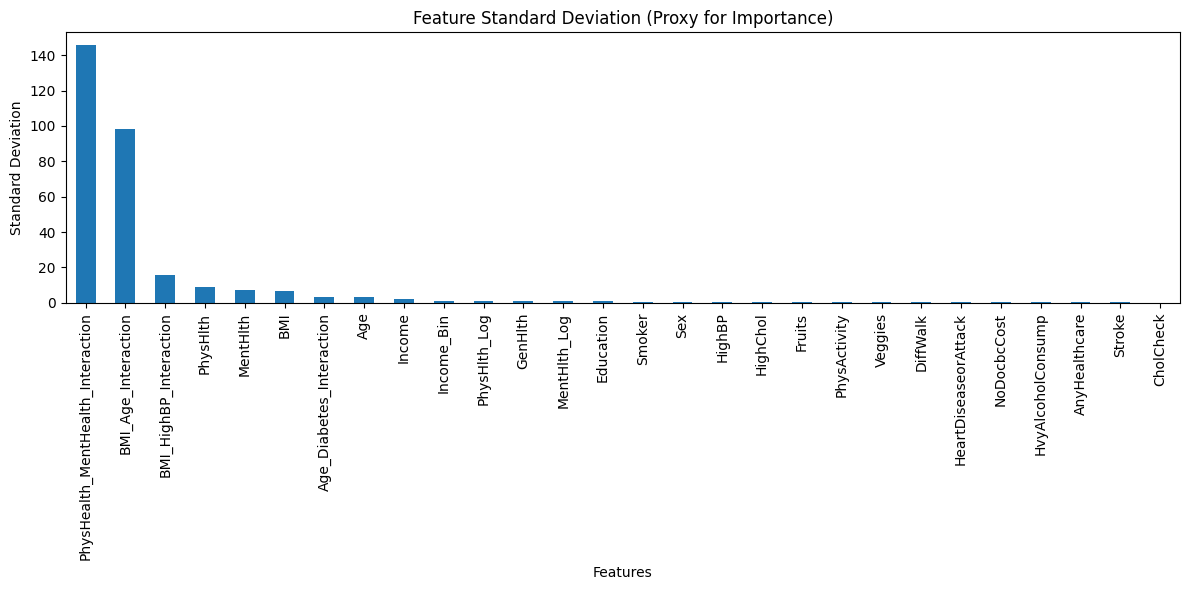

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_fscore_support,
    balanced_accuracy_score
)
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

def feature_engineering(df):
    df['BMI_Age_Interaction'] = df['BMI'] * df['Age']
    df['PhysHealth_MentHealth_Interaction'] = df['PhysHlth'] * df['MentHlth']

    def custom_binning(series, n_bins=5):
        try:
            bins = pd.qcut(series, q=n_bins, labels=False, duplicates='drop')
        except ValueError:
            min_val, max_val = series.min(), series.max()
            bin_edges = np.linspace(min_val, max_val, num=n_bins+1)
            bins = pd.cut(series, bins=bin_edges, labels=False, include_lowest=True)

        return bins

    df['Income_Bin'] = custom_binning(df['Income'])

    skewed_features = ['PhysHlth', 'MentHlth']
    for feature in skewed_features:
        df[f'{feature}_Log'] = np.log1p(df[feature])

    df['Age_Diabetes_Interaction'] = df['Age'] * (df['Diabetes_012'] == 2).astype(int)
    df['BMI_HighBP_Interaction'] = df['BMI'] * df['HighBP']

    return df

def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)

    df = feature_engineering(df)

    X = df.drop('Diabetes_012', axis=1)
    y = df['Diabetes_012']

    return X, y

filepath = '/content/diabetes_012_health_indicators_BRFSS2015.csv'
X, y = load_and_preprocess_data(filepath)

final_model = train_and_evaluate(X, y)

torch.save(final_model.state_dict(), 'advanced_diabetes_model.pth')

def plot_feature_importance(X):
    plt.figure(figsize=(12, 6))
    feature_importance = X.std()
    feature_importance.sort_values(ascending=False).plot(kind='bar')
    plt.title('Feature Standard Deviation (Proxy for Importance)')
    plt.xlabel('Features')
    plt.ylabel('Standard Deviation')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plot_feature_importance(X)